<p style="font-size: 45px; font-weight: bold; color: grey;">InPoDa : projet réalisé par Ahmad HATOUM</p>


Voici ci-dessous le code que j'ai réalisé pour le projet **InPoDa**, une plateforme pour l’analyse de données de réseaux sociaux, plus particulièrement de tweets. <br> <br>
Mon avancé le long du projet est présente sur mon **Github**, dans le répertoire suivant : https://github.com/uvsq22202060/projet_InPoDa


Vous trouverez différents "chapitres" du projet décrivant au mieux possible (à travers les commentaires, etc) les différentes parties permettant la réalisation du code.

    FONCTIONNEMENT d'InPoDa

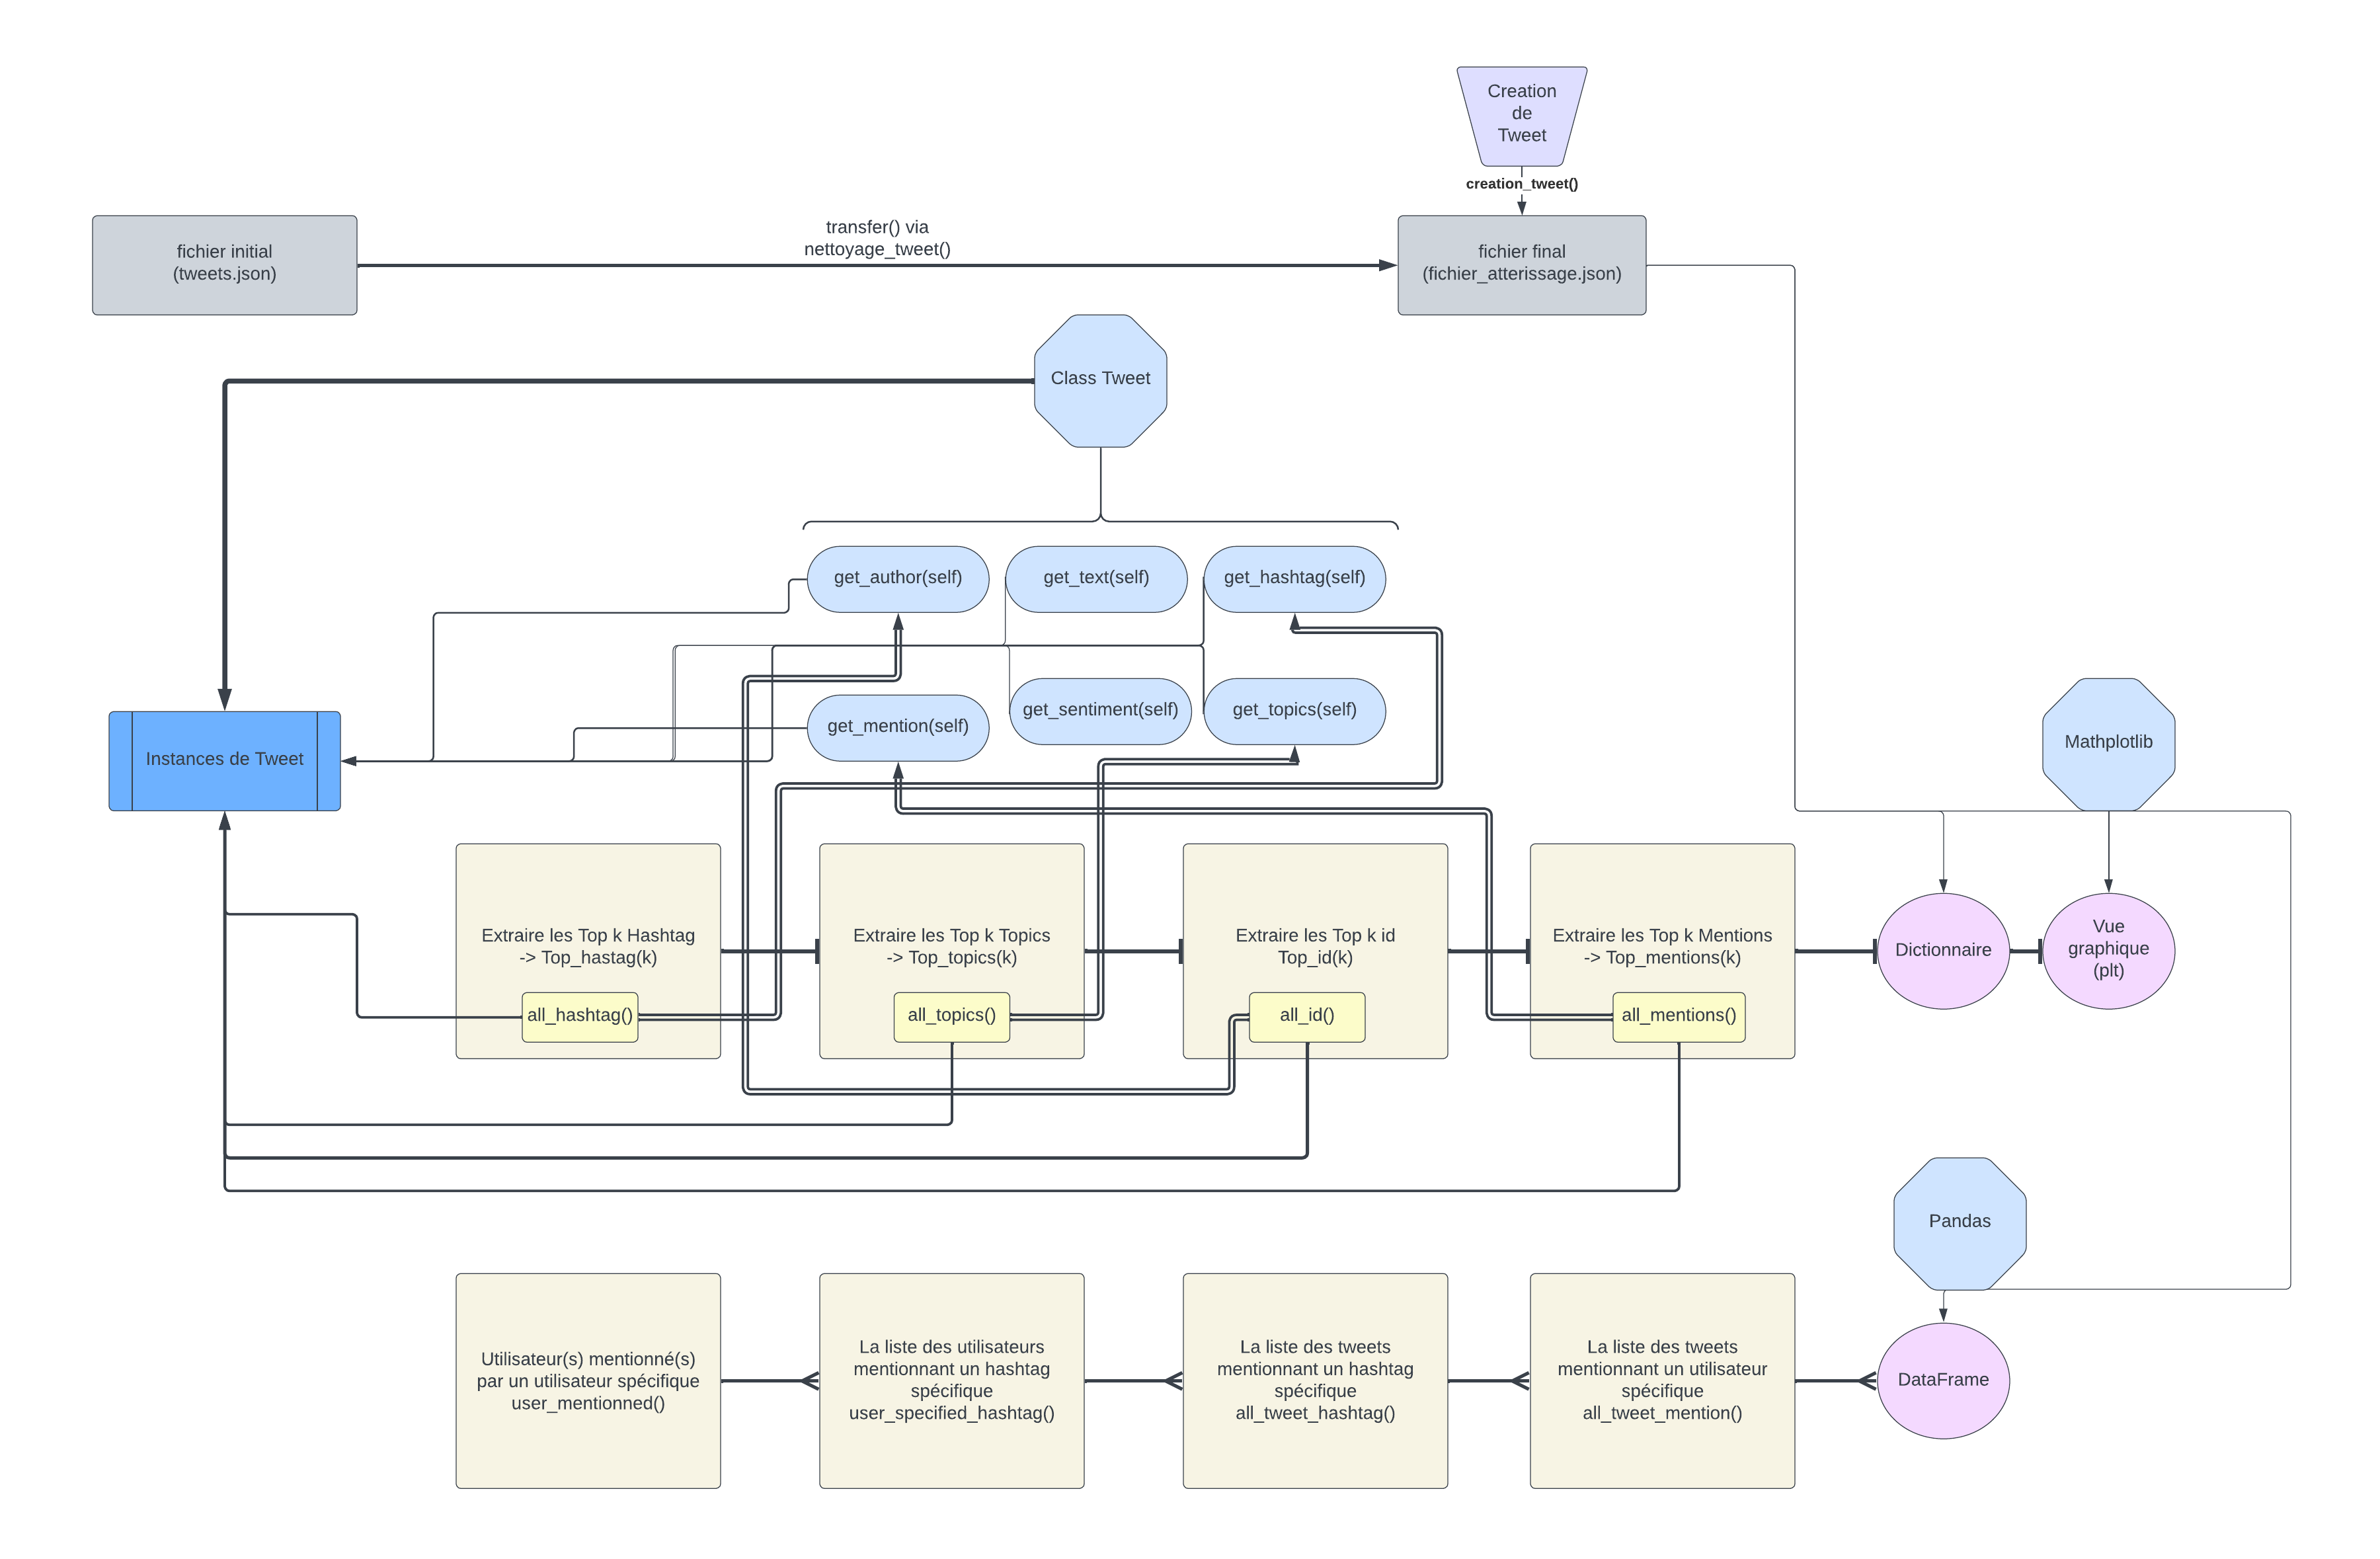

In [2]:
# code généré par CHATGPT (l'affichage n'était pas fonctionnel)

from pdf2image import convert_from_path
from IPython.display import display, Image

# Spécifiez le chemin du fichier PDF
pdf_path = "Fonctionnement_InPoDa.pdf"

# Convertissez les pages du PDF en images
images = convert_from_path(pdf_path)

# Affichez chaque image dans une cellule
for i, image in enumerate(images):
    image_path = f"{pdf_path}_page_{i + 1}.png"
    image.save(image_path, "PNG")
    display(Image(filename=image_path))


    IMPORTS ET MODULES
Cette partie rassemble l'ensemble des imports des modules qui sont utilisés tout le long du code de **InPoDa**.

* Certains modules nécessitent d'être installé   
Il se peut ne pas être le cas, dans ce cas-là veuillez exécuter "pip install *module*" pour chaque module

In [3]:
import json                         # module pour load le file
import re                           # module pour retourner les hasthtags
from textblob import TextBlob       # module pour analyser le sentiment du tweet
import pandas as pd                 # module pour visualiser et comparer les tweets
import matplotlib.pyplot as plt     # module pour la création de Diagramme
from datetime import datetime       # module pour manipuler l'heure 
import random as rd                 # module pour générer des éléments aléatoires
import langid                       # module pour reconnaitre la langue d'un tweet
import spacy                        # module pour extraire le(s) sujet(s) d'un tweet
nlp = spacy.load("en_core_web_sm")  # chargement du "Trained pipeline" de spacy ici anglais

    GESTION DES TWEETS
Cette partie rassemble les deux fonctions qui permettent de traiter l'ensemble des tweets, en passant par le nettoyage des caractères et la création de la zone d’atterrissage qui contiendra les possibles nouveaux tweets de l'utilisateur. <br> ⚠️ Pour ce projet, j'ai utilisé la premère base de données "aitweets.json", que j'ai renommé en "tweets.json" (dont j'ai eu l'approbation de l'utilisation par le professeur)

In [4]:
def text_cleaning(text):
  '''retourne le texte entrée, nettoyer de tous symboles/emojis'''
  # Pattern trouvé sur le lien suivant : https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1#gistcomment-3208085
  
  pattern = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
                      )
  
  text = re.sub(pattern, r'', text)                              # ici l'expression regulière va supprimer (sub en anglais) les émojis et caractères contenus dans le pattern
  return text

def transfer(source, destination):
  '''retourne une zone d'atterrissage, une base de données nettoyée'''
  with open(source,"r") as source_file, open(destination,"w") as destination_file :       # on ouvre le fichier source (-> source_file) et fichier destination (-> destination_file)

      content_source = source_file.read()                        # on extrait le contenu de notre fichier source que l'on attribue à la variable content_source
      content_source = text_cleaning(content_source)             # on nettoie le contenu obtenu (pour supprimer les emojis...)

      destination_file.write(content_source)                     # on écrit le contenu dans le fichier de destination

#transfer("tweets.json","fichier_atterrissage.json")             # cette ligne de code permet la création de la zone d’atterrissage (nettoyé)

# Data utilisé pour la création des dictionnaires pour faciliter l'analyse de diagramme,...
file = open("fichier_atterrissage.json","r")
data =json.load(file)
file.close()

# Data utilisé pour analyser visuellement les différentes caractéristiques d'un tweet
data2 = pd.read_json("fichier_atterrissage.json")
df_data = pd.DataFrame(data2)

    CLASS "Tweet"
Cette partie présente la construction de la class "Tweet" qui sert de véritable colonne vertébrale pour **InPoDa**. 

In [5]:
class Tweet :
    def __init__(self,id_tweet,location_tweet,creation_tweet,retweet_count,tweet_language,tweet_text) :
        self.id        = id_tweet
        self.location  = location_tweet
        self.created   = creation_tweet
        self.retweet   = retweet_count
        self.language  = tweet_language
        self.text      = tweet_text
    
    def __str__(self):
        return f"id : {self.id}\nAuthorLocation : {self.location} \nCreatedAt : {self.created} \nRetweetCount: {self.retweet} \nTweetLanguage : {self.language} \nTweetText : {self.text}"
    
    def get_author(self):
        id_tweet = self.id
        return id_tweet
    
    def get_text(self):
        return self.text
    
    def get_hashtags(self):
        return re.findall(r"#(\w+)", self.text)         # utilisation de l'expression régulière en recherchant la valeur venant après un # dans le texte

    def get_mention(self):
        return re.findall(r"@(\w+)", self.text)         # utilisation de l'expression régulière en recherchant la valeur venant après un @ dans le texte
    
    def get_sentiment(self):                            # afin de profiter un maximum de la méthode, la majorité des tweets sera en anglais 
        text = TextBlob(self.text)                      # on analyse la phrase avec le module TextBlob, en créant un "blob" à partir de notre texte
        text_polarity = text.sentiment.polarity         # on extrait la valeur associée à la polarité du texte
        if text_polarity > 0 :   return "Positive"      # et on retourne le sentiment associé : si polarité > 0 -> le texte est principalement positif
        elif text_polarity < 0 : return "Negative"      # si polarité < 0 -> le texte est principalement négatif
        else :                   return "Neutral"       # sinon si polarité = 0 -> le texte est principalement neutre
    
    def get_topic(self):                                # https://spacy.io/usage/linguistic-features#pos-tagging
        text = self.text
        topics = []
        doc = nlp(text)                                 # on analyse la phrase avec le module SpaCy
        for token in doc :                              # on parcourt chaque élément de la phrase (token)
            if token.text == "#": continue              # on esquive le "#" dans notre liste car ce n'est pas cohérent
            elif token.pos_ == "NOUN" :                 # on vérifie si celui-cii est un Nom dans la phrase (sa position lexicale)
                topics.append(token.text)               # dans ce cas-là on l'ajoute à notre liste de sujets                                                        
        return topics


#instance / objets de la class "Tweet"
tweets = [Tweet(tweet["id"],tweet["AuthorLocation"],tweet["CreatedAt"],tweet["RetweetCount"],tweet["TweetLanguage"],tweet["TweetText"]) for tweet in data]

    FONCTIONS D'ANALYSE
Cette partie rassemble les différentes fonctions d'analyse d'**InPoDa** avec la base de données avec différentes structures : les **dictionnaires** et les **dataframes**.

Les **dictionnaires** sont des structures que j'ai choisies pour faciliter la réalisation des graphes d'analyse (dans l'accès au comptage des différents paramètres).<br> <br>
Les **dataframes** sont intéressants lors de la visualisation de l'ensemble des informations du tweet.

In [6]:
###########################################################################################################################
################################################## AVEC LES DICTIONNAIRES   ###############################################
###########################################################################################################################


# Pour Top K Hashtags -> 2 fonctions

# La première :
def all_hashtag():
    '''retourne tout les hashtags présents dans la database'''
    l = []                                         # on initialise la liste qui va être retournée à l'exécution de la fonction
    for tweet in tweets:                           # on parcourt tous les tweets (un par un)
        if tweet.get_hashtags() == [] :            # on vérifie avec l'attribut de l'instance si la valeur retournée est  "[]" <- pas de valeur ; dans ce cas-là on passe au tweet suivant
            continue
        else :
            temp = tweet.get_hashtags()            # on affecte à temp (variable temporaire) la liste des hashtags de chaque tweet
            for hashtag in temp :                  # on accède à chacun des hashtags présents dans temp
                l.append(hashtag)                  # on les affecte à la liste finale qui sera retournée
                
    return l
    
   
# La deuxième :
def top_hashtag(k):
    '''retourne le top k hashtags utilisé dans la database'''
    hashtags = all_hashtag()                      # utilisation de la fonction all_hashtag() pour récupérer la liste complète des hashtag
    hashtag_count = {}                            # on initialise un dictionnaire vide pour compter chaque occurrence de chaque hashtag
    for hashtag in hashtags :                     # ici on prend chaque hashtag un par un
        if hashtag in hashtag_count :             # on vérifie si "hashtag" est dans le dictionnaire qui compte les occurrences
            hashtag_count[hashtag] += 1           # dans ce cas-là on incrémente sa valeur de 1
        else :
            hashtag_count[hashtag] = 1            # dans le cas contraire, on initialise la clé "hashtag" à une valeur initiale de 1 

    hashtag_count = dict(sorted(hashtag_count.items(),key = lambda x : x[1], reverse=True)) # on trie le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(hashtag_count.items())[:k]        # on convertit le dictionnaire en une liste pour pouvoir effectuer un slicing (afin d'obtenir le top k élément) 
    top_k_hashtag = dict(temp)                    # on reconvertit en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un ordre précis
    
    # Diagramme avec plt
    x_hashtag = list(top_k_hashtag.keys())        # on affecte à la variable x_hashtag les clés du dictionnaire (les hashtags (str))
    y_occurrence = list(top_k_hashtag.values())   # on affecte à la variable y_occurrence les valeurs des clés du dictionnaire (les occurrences)

    plt.bar(x_hashtag,y_occurrence)               # on crée le diagramme en bar avec en x -> x_hashtag et en y -> y_occurrence
    plt.xlabel("Hashtag")                         # "Hashtag" comme titre de l'axe des x
    plt.ylabel("Occurrence")                      # "Occurrence" comme titre de l'axe des y

    plt.xticks(rotation=45, ha="right")           # on précise l'affichage des données en x, les hashtags (en diagonale afin de pouvoir éviter le chevauchement des valeurs)
    plt.show()                                    # affichage du diagramme

    return top_k_hashtag                          # on retourne en même temps le dictionnaire trié en ordre croissant des top k hashtags

#########################################################################################################################

# Pour Top K Users -> 2 fonctions 

# La première : 
def all_users():
    '''retourne tout les utilisateurs présents dans la database'''
    l = []                                       # on initialise la liste qui va être retournée à l'exécution de la fonction
    for tweet in tweets:                         # on parcourt tous les tweets (un par un)
        user = tweet.get_author()                # on extrait l'auteur grâce à la méthode .get_author() qu'on place dans la variable user
        l.append(user)                           # on ajoute à la liste l'utilisateur/id du tweet
                
    return l

# La deuxième : 
def top_users(k):
    '''retourne le top k utilisateurs/id présents dans la database'''
    users = all_users()                          # utilisation de la fonction all_users() pour récupérer la liste complète des utilisateurs
    user_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurrence de chaque id
    for user in users :                          # ici on prend chaque id un par un, ici nommé "user"
        if user in user_ntweet :                 # on vérifie si l'id est déjà dans le dictionnaire
            user_ntweet[user] += 1               # si c'est le ce cas, on incrémente sa valeur de 1 
        else :
            user_ntweet[user] = 1                # sinon on crée une clé pour l'id correspondant et on initie sa valeur à 1 

    user_ntweet = dict(sorted(user_ntweet.items(), key = lambda x : x[1], reverse=True)) # on trie le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(user_ntweet.items())[:k]         # on convertit le dictionnaire en une liste pour pouvoir effectur un slicing (afin d'obtenir le top k élément)
    top_k_users = dict(temp)                     # on reconvertit en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un ordre précis

    x_user = list(top_k_users.keys())            # on affecte à la variable x_user les clés du dictionnaire (les id (str))
    y_occurrence = list(top_k_users.values())    # on affecte à la variable y_occurrence les valeurs du dictionnaire (les occurrences)

    plt.bar(x_user,y_occurrence)                 # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurrence
    plt.xlabel("User")                           # "User" comme titre de l'axe des x
    plt.ylabel("Occurrence")                     # "Occurrence" comme titre de l'axe des y

    plt.xticks(rotation=45, ha="right")          # on précise l'affichage des données en x, les id (en diagonale afin de pouvoir éviter le chevauchement des valeurs)
    plt.show()                                   # affichage du diagramme

    return top_k_users                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k users

#########################################################################################################################

# Pour the top K mentions -> 2 fonctions 
 
# La première :
def all_mentions():
    '''retourne toutes les mentions de la database'''
    l = []                                        # on initialise la liste qui va être utilisée pour retourner les mentions à l'exécution de la fonction
    for tweet in tweets:
        if tweet.get_mention()== [] :             # on vérifie avec l'attribut de l'instance si la valeur retournée est  "[]" <- pas de valeur ; dans ce cas-là on passe au tweet suivant
            continue
        else :
            mentions = tweet.get_mention()        # on place les mentions obtenues du tweet dans la variable temporaire mentions (qui va correspondre à une liste) 
            for mention in mentions :             # on parcours chaque élément de la liste (ils peuvent être dans une liste de liste par exemple :[[mention],mention2,...])
                l.append(mention)                 # et on l'ajoute à notre liste finale
                
    return l

# La deuxième :
def top_mention(k):
    '''retourne le top k mentions présentes dans la database'''
    mentions = all_mentions()                       # utilisation de la fonction all_mentions() pour récupérer la liste complète des mentions
    mention_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurrence de chaque mention
    for mention in mentions :                       # ici on prend chaque mention, une par une
        if mention in mention_ntweet :              # on vérifie si la mention est présente dans le dictionnaire
            mention_ntweet[mention] += 1            # dans ce cas là on incrémente la valeur corresponde à la mention (la clé)
        else :
            mention_ntweet[mention] = 1             # dans le cas contraire on initie la clé correspondante à la mention à 1

    mention_ntweet = dict(sorted(mention_ntweet.items(),key = lambda x : x[1], reverse=True)) # on trie le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(mention_ntweet.items())[:k]         # on convertit le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_mentions = dict(temp)                     # on reconvertit la liste en dictionnaire trié en ordre croissant des top k mentions

    x_mention = list(top_k_mentions.keys())         # on affecte à la variable x_mention les clés du dictionnaire (les mentions (str))
    y_occurrence = list(top_k_mentions.values())    # on affecte à la variable y_occurrence les valeurs du dictionnaire (les occurrences)

    plt.bar(x_mention,y_occurrence)                 # on créer le diagramme en bar avec en x -> x_mention et en y -> y_occurrence
    plt.xlabel("Mention",)                          # on créer le diagramme en bar avec en x -> x_mention
    plt.ylabel("Occurrence")                        # on créer le diagramme en bar avec en y -> y_occurrence

    plt.xticks(rotation=45, ha="right")             # on précise l'affichage des données en x, les mentions (en diagonale afin de pouvoir éviter le chevauchement des valeurs)
    plt.show()                                      # affichage du diagramme

    return top_k_mentions                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k mentions

#########################################################################################################################

# Pour the top K topics -> 2 fonctions 

# La première :
def all_topics():
    '''retourne tous les topics de la database'''
    l = []                                              # on initialise la liste qui va être utilisée pour retourner les mentions à l'exécution de la fonction
    for tweet in tweets:
        topics = tweet.get_topic()                      # on place les mentions obtenues du tweet dans la variable temporaire mentions (qui va correspondre à une liste) 
        for topic in topics :                           # on parcours chaque élément de la liste (ils peuvent être dans une liste de liste par exemple :[[mention],mention2,...])
            l.append(topic)                             # et on l'ajoute à notre liste finale
                
    return l

# La deuxième : 
def top_topics(k):
    '''retourne le top k topics/sujets de tweet présents dans la database'''
    topics = all_topics()                               # utilisation de la fonction all_topics() pour récupérer la liste complète des topics
    topics_ntweet = {}                                  # on initialise un dictionnaire vide pour compter chaque occurrence de chaque topic
    for topic in topics :                               # ici on prend chaque topic, un par un
        if topic == "#" :
            continue                              
        elif topic in topics_ntweet :                   # on vérifie si le topic est présent dans le dictionnaire
            topics_ntweet[topic] += 1                   # dans ce cas là on incrémente la valeur correspondante au topic (la clé)
        else :
            topics_ntweet[topic] = 1                    # dans le cas contraire on initie la clé correspondante à la mention à 1

    topics_ntweet = dict(sorted(topics_ntweet.items(),key = lambda x : x[1], reverse=True)) # on trie le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(topics_ntweet.items())[:k]              # on convertit le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_topics = dict(temp)                           # on reconvertit la liste en dictionnaire trié en ordre croissant des top k topics

    x_topic = list(top_k_topics.keys())                 # on affecte à la variable x_topic les clés du dictionnaire (les mentions (str))
    y_occurrence = list(top_k_topics.values())          # on affecte à la variable y_occurrence les valeurs du dictionnaire (les occurrences)

    plt.bar(x_topic,y_occurrence)                       # on créer le diagramme en bar avec en x -> x_topic et en y -> y_occurrence
    plt.xlabel("Topic",)                                # on créer le diagramme en bar avec en x -> x_topic
    plt.ylabel("Occurrence")                            # on créer le diagramme en bar avec en y -> y_occurrence

    plt.xticks(rotation=45, ha="right")                 # on précise l'affichage des données en x, les topics (en diagonale afin de pouvoir éviter le chevauchement des valeurs)
    plt.show()                                          # affichage du diagramme

    return top_k_topics 
    


###########################################################################################################################
################################################## AVEC LES DATAFRAMES   ##################################################
###########################################################################################################################


def all_tweet_mention(mention):
    '''retourne l'ensemble des tweets mentionnant un utilisateur spécifique dans un dataframe'''                                                               
    return df_data[df_data["TweetText"].str.contains(f"@{mention}")]                          # on trie les lignes de la database pour extraire seulement celle qui contiennent @mention dans la colonne 

def all_tweet_hashtag(hashtag):
    '''retourne l'ensemble des tweets faisant référence à un hashtag spécifique'''                                                               
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}")]                          # on trie les lignes de la database pour extraire seulement celle qui contiennent #hashtag dans la colonne de TweetText

def user_specified_hashtag(hashtag):
    '''retourne les id de chaque utilisateur mentionnant un hashtag spécifique'''                                                         
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}")].get("id")                # on trie les lignes de la database pour extraire  les #hashtag présent dans la colonne TweetText et on extrait seulement les id

def user_mentionned(user):
    '''retourne les utilisateurs mentionnés par un utilisateur spécifique'''                                                                
    text = str(df_data[df_data["id"]==user].get("TweetText"))                                 # on attribue à la variable text le texte du tweet qui correspond à l'utilisiateur spécifique
    return re.findall(r"@(\w+)", text)                                                        # on nettoie le text en extrayant les mentions avec le r"@(\w+)"



    CREATION DE TWEET
Cette partie relève de la structure utilisée lors de la création d'un tweet via **InPoDa** en simulant différents paramètres comme la **date** (en prenant la date actuelle), la **localisation** (aléatoire) et son insertion dans la base de données d'arrivée. 

In [7]:
################################################# PARTIE SUR LA CREATION DE TWEET #############################################################

def creation_time():
    '''retourne la date, l'heure, ... actuelle dans le format utilisé dans la database'''
    actual_time = datetime.now()                                          # on attribue la date actuelle à la variable actual_time 
    actual_time = actual_time.strftime("%Y-%m-%dT%H:%M:%SZ")              # on reformatise la date avec le format correspondant au fichier json, https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
    return actual_time

def random_location():
    '''retourner une ville aléatoire pour simuler la localisation de l'auteur du tweet'''                                                    
    locations = [                                                          # locations est une liste de "Ville, Pays"
                "Tokyo, Japan", 
                "New York City, United-States",
                "London, England",
                "Pekin, China",
                "Paris, France",
                "Montreal, Canada",
                "Madrid, Spain",
                "Los Angeles, United-States",
                "Delhi, India",
                "Beirut, Lebanon",
                "Versailles, France",
                "Amsterdam, Netherland",
                "Shanghai, China",
                "Moscou, Russia",
                "São Paulo, Brasil"
                ]
    
    return locations[rd.randint(0,len(locations)-1)]                     # on va retourner un ville aléatoire avec l'utilsation du module random (pour l'index)

def create_tweet():
    '''Fonction qui va permettre d'écrire un tweet et de l'intégrer dans la database'''  

    text_tweet = text_cleaning(input("Que voulez vous tweetez ?"))       # le contenu de notre tweet est récupérer dans la variable text_tweet après être nettoyé
    tweet_lang,_ = langid.classify(text_tweet)                           # la langue est extraite de la variable text_tweet grace au module langid
    tweet = {                                                            # dictionnaire qui va contenir les informations sur le tweet
        "id": str(rd.randint(1000000000000000000,2000000000000000000)),  # on attribue un id aléatoire dans un interval semblable à celui de base
        "AuthorLocation": random_location(),                             # on appelle la fonction random_location() pour générer un emplacement aléatoire pour le tweet
        "CreatedAt": creation_time(),                                    # on extrait l'heure actuelle où est rédigé le tweet (tout en faisant attention à sa mise en forme, voir fonction)
        "RetweetCount": rd.randint(1,10),                                # on génère un nombre de retweet
        "TweetLanguage": tweet_lang,                                     # on extrait la langue du tweet avec le module langid
        "TweetText": text_tweet                                          
            }

    try:                                                                 # permet de vérifier si le fichier est non vide (https://stackoverflow.com/questions/22366282/python-filenotfound l'importance du except FileNotFoundError pour éviter d'ajouter dans le vide)
        with open("fichier_atterrissage.json", "r") as file:              
            database = json.load(file)                                   # si non vide alors on load/charge le contenu dans la variable database
    except FileNotFoundError:                                            # sinon, on crée la base de donnée nous même
         
         database = []                                                   # création de la base de donnée (en liste pour pouvoir manipuler les tweets correctement)


    database.append(tweet)                                               # on ajoute à la suite de la database notre tweet créer

    
    with open("fichier_atterrissage.json", "w") as file:
        json.dump(database, file,indent=3,ensure_ascii=False)            # sans le ensure ascii = False on aurait des \u... quand on mets des accents https://stackoverflow.com/questions/40412714/using-json-dumps-with-ensure-ascii-true, dumps permet d'assurer des données json

file = open("fichier_atterrissage.json","r")
data =json.load(file)
file.close()

# Mise à jour de la database (avec le tweet créé ajouté)
data2 = pd.read_json("fichier_atterrissage.json")
df_data = pd.DataFrame(data2)
#instance/ objets de la class
tweets = [Tweet(tweet["id"],tweet["AuthorLocation"],tweet["CreatedAt"],tweet["RetweetCount"],tweet["TweetLanguage"],tweet["TweetText"]) for tweet in data]

    ** SECTION DE TEST **
Cette dernière partie rassemble l'ensemble des fonctionnalités de **InPoDa**, vous pouvez y réaliser différents tests

* petit aparté : les correspondances d'id sont légèrement erronées entre dataframe et dictionnaire.<br><br>
Donc les ids retrouvés dans l'une des deux structures sont identiques, en revanche il est possible d'avoir quelque chiffre en plus/en moins <br><br>
par exemple : user_mentionned(1418705513660010496) va retourner un dataframe pour le tweet de l'id : 1418705513660010496<br> <br>
en revanche il se peut que cet id soit légèrement différent dans la base de données (ce n'est pas le cas ici)


In [8]:
print(tweets[0])  # cette ligne de code montre l'importance de la méthode __str__(self) de la class Tweet qui permet d'avoir un aperçu correct du tweet en question et non de ces sources

id : 1415291947560828933
AuthorLocation : Mysore  and  BERLIN 
CreatedAt : 2021-07-14T12:47:49Z 
RetweetCount: 2 
TweetLanguage : en 
TweetText : RT @HDataSystems: Artificial Intelligence and Augment Analytics Shaping Financial Sector https://t.co/Mi3BohmgDh 

#hdatasystems #Artificia…


In [9]:
tweets[7].get_author()

'1415307247010213893'

In [10]:
tweets[7].get_hashtags()

['AI', 'ArtificialIntelligence']

In [11]:
tweets[100].get_mention()     # on considère les RT comme des mentions lors de la perception des tweets

['tarabilion', 'AIFinancein', 'emexgraphixx', 'emeka_okafor', 'Gem']

In [12]:
tweets[100].get_text()

'RT @tarabilion: @AIFinancein Artificial intelligence is an amazing project, am happy to be part of this.\n@emexgraphixx \n@emeka_okafor \n@Gem…'

In [13]:
tweets[100].get_sentiment()

'Positive'

In [14]:
tweets[100].get_topic()                # on remarque la non-exactitude de quelques résultats avec spacy

['@tarabilion', 'intelligence', 'project', 'part', '@emexgraphixx']

In [15]:
all_hashtag()

['hdatasystems',
 'Artificia',
 'MachineLearning',
 'DataScience',
 'Python',
 'AI',
 '100DaysOfCode',
 'DEVCommunity',
 'IoT',
 'flutte',
 'artificialintelligence',
 'AI',
 'ArtificialIntelligence',
 'DeepLearning',
 'AI',
 'ArtificialIntelligence',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'data',
 'science',
 'Tensorflow',
 'artificial',
 'intelligence',
 'python',
 '100daysofcode',
 'coding',
 'udemy',
 'Artificial_Intelligence',
 'ai',
 'ml',
 'dl',
 'artificialintelligence',
 'Intela',
 'ArtificialIntelligence',
 'Ar',
 'ArtificialIntelligenc',
 'GovCloudWorldNews',
 'ArtificialIntelligence',
 'Java',
 'Bitcoin',
 'SciketLearn',
 'ComputerVision',
 'DeepLearningFramework',
 'AutonomousVehicles',
 'NFT',
 'ImageProcessing',
 'React',
 'LinearAlgebra',
 'Bluetooth',
 'AI',
 'Robotics',
 'Automation',
 'Ro',
 'Robotics',
 'Automation',
 'Ro',
 'ArtificialIntelligence',
 'REAL

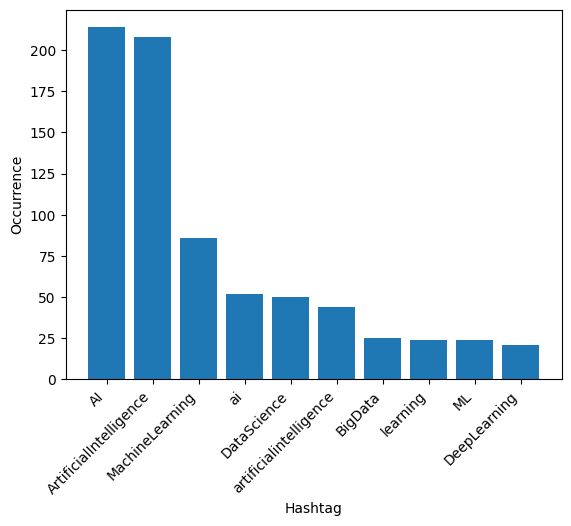

{'AI': 214,
 'ArtificialIntelligence': 208,
 'MachineLearning': 86,
 'ai': 52,
 'DataScience': 50,
 'artificialintelligence': 44,
 'BigData': 25,
 'learning': 24,
 'ML': 24,
 'DeepLearning': 21}

In [16]:
top_hashtag(10)             # on retourne aussi le dictionnaire hashtag : occurrence pour pouvoir accèder à la donnée rapidement

In [17]:
all_users()

['1415291947560828933',
 '1415291877897605120',
 '1415291886860967940',
 '1415291968700264450',
 '1415292139941109763',
 '1415292142256365573',
 '1415292148967223298',
 '1415307247010213893',
 '1415307203645296642',
 '1415307239657811971',
 '1415307213929861124',
 '1415307277913968651',
 '1415322365664321549',
 '1415322360480141314',
 '1415322343241617411',
 '1415322343300386819',
 '1415337402181328902',
 '1415337471915794440',
 '1415337433634414592',
 '1415337477741506565',
 '1415337411350040593',
 '1415352584785698816',
 '1415352563935981571',
 '1415352547389345792',
 '1415352586710962185',
 '1415352546248511495',
 '1415367669100912640',
 '1415367645554257925',
 '1415367613895565313',
 '1415367653666000896',
 '1415367613002178563',
 '1415382737557544966',
 '1415382787675328524',
 '1415382772412297219',
 '1415382714719604740',
 '1415382718603481089',
 '1415397770840592385',
 '1415397895822614529',
 '1415397774292443136',
 '1415397807998001152',
 '1415412761593630725',
 '14154129601181

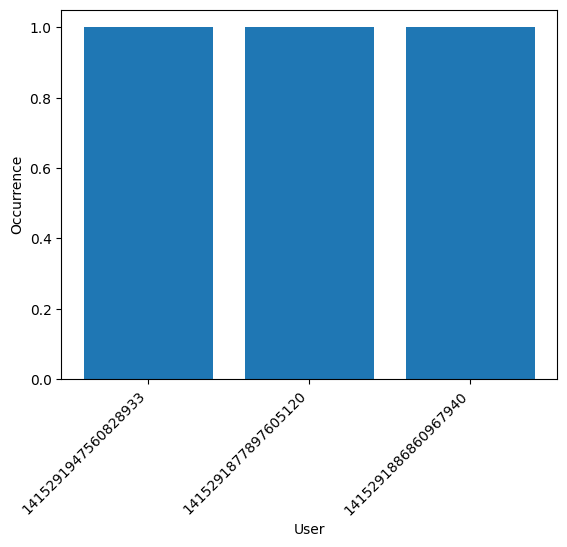

{'1415291947560828933': 1, '1415291877897605120': 1, '1415291886860967940': 1}

In [18]:
top_users(3)                # cette fonction n'est pas pertinante dans l'usage de cette base de donnée

In [19]:
all_mentions()

['HDataSystems',
 'adgpi',
 'pacorjo',
 'HarbRimah',
 'weblineglobal',
 'sokoworlddotcom',
 'SuriyaSubraman',
 'DD_FaFa_',
 'ahmad',
 'williamhersh',
 'VAIOT_LTD',
 'mobileappdaily',
 'Gizchina',
 'byLilyV',
 'byLilyV',
 'DGWilkinson',
 'pb3060',
 'AINewsFeed',
 'SPHEREEdu',
 'adgpi',
 'nigewillson',
 'sacred0asis',
 'Mxyzptlk07',
 'intocryptoverse',
 'animalethics',
 'cryptow1re',
 'OfficialIndiaAI',
 'IntelaSolutions',
 'IainLJBrown',
 'machinelearnflx',
 'thextraordinari',
 'tommyn1965',
 'nlynnimani66',
 'Valeria_Colucci',
 'ZaackHunt',
 'AJBlackston',
 'machine_ml',
 'hubofml',
 'machinelearnTec',
 'SecDef',
 'DeptofDefense',
 'drjohnmorley',
 'sh_hameed',
 'IainLJBrown',
 'Kevin_Jackson',
 'DrJDrooghaag',
 'VisiveAI',
 'VisiveAI',
 'Datascience__',
 'ManuelaKC',
 'Entrepreneur',
 'SoyEntrepreneur',
 'pulitzercenter',
 'GranthshalaNews',
 'Udemy_Coupons1',
 'Udemy_Coupons1',
 'knowprogram',
 'byLilyV',
 'ItamaratyGovBr',
 'govbr',
 'andi_staub',
 'Paula_Piccard',
 'andy',
 'uniden

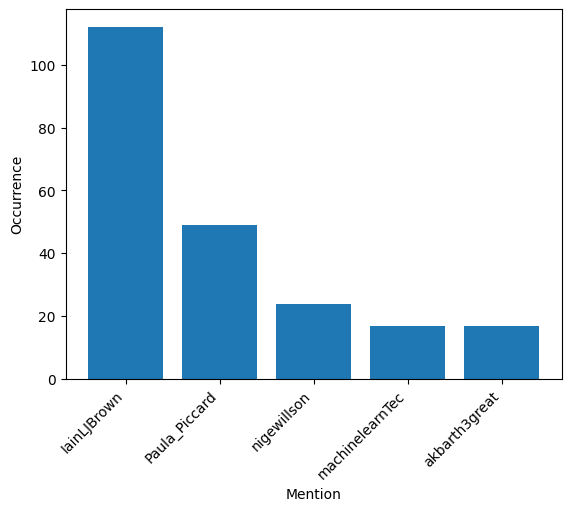

{'IainLJBrown': 112,
 'Paula_Piccard': 49,
 'nigewillson': 24,
 'machinelearnTec': 17,
 'akbarth3great': 17}

In [20]:
top_mention(5)

In [21]:
all_topics()   # l'exécution est plus longue que le reste des fonctions, cela est dû à l'analyse qui est faites avec spacy (d'où le terme "deeplearning")

['@HDataSystems',
 '22nd',
 'review',
 'niche',
 'projects',
 'field',
 'survey',
 'industry',
 'dollars',
 'DEVCommunity',
 'flutte',
 'applications',
 'artificialintelligence',
 'span',
 'directions',
 'fields',
 'life',
 'Customers',
 'devices',
 'computers',
 'programs',
 'degree',
 'diploma',
 'certificates',
 'Investments',
 '_',
 'Prediction',
 'Machines',
 'https://t.co/8nFi64UIEx',
 'post',
 'blog',
 'intelligence',
 'challenge',
 'biomedi',
 'Pioneers',
 'plans',
 'future',
 'world',
 'world',
 'ar',
 '…',
 'G',
 'paper',
 'explanation',
 'intelligence',
 'G',
 'syste',
 'COURSES',
 'hands',
 'machine',
 'tutoria',
 'COURSES',
 'hands',
 'machine',
 'tutoria',
 'COURSES',
 'hands',
 'machine',
 'tutorial',
 'data',
 'science',
 'intelligence',
 'networks',
 'udemy',
 'https://t.co/3T3EbEU6B8',
 'intelligence',
 'world',
 'fire',
 '@pb3060',
 'topo',
 'Artificial_Intelligence',
 'https://t.co/UnaYZWjR1D',
 'trends',
 'opportunities',
 'dl',
 'intelligence',
 'technology',
 'sp

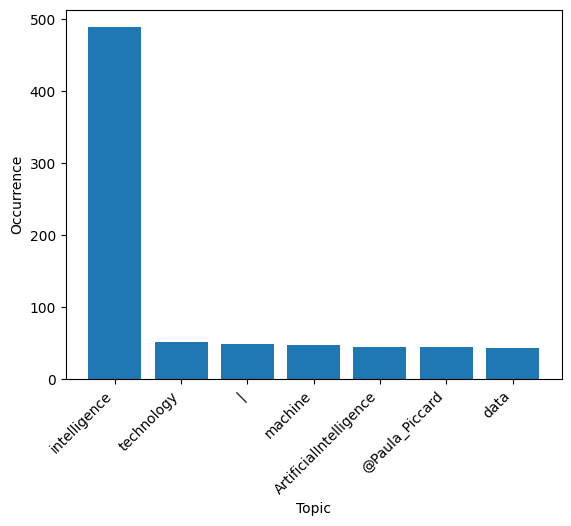

{'intelligence': 489,
 'technology': 52,
 '|': 49,
 'machine': 48,
 'ArtificialIntelligence': 44,
 '@Paula_Piccard': 44,
 'data': 43}

In [22]:
top_topics(7)     # le résultat de l'interprétation est choisie par spacy qui peut considérer une personne (ex : @Paula_Ricard) comme véritable topic

In [57]:
all_mentions()

['HDataSystems',
 'adgpi',
 'pacorjo',
 'HarbRimah',
 'weblineglobal',
 'sokoworlddotcom',
 'SuriyaSubraman',
 'DD_FaFa_',
 'ahmad',
 'williamhersh',
 'VAIOT_LTD',
 'mobileappdaily',
 'Gizchina',
 'byLilyV',
 'byLilyV',
 'DGWilkinson',
 'pb3060',
 'AINewsFeed',
 'SPHEREEdu',
 'adgpi',
 'nigewillson',
 'sacred0asis',
 'Mxyzptlk07',
 'intocryptoverse',
 'animalethics',
 'cryptow1re',
 'OfficialIndiaAI',
 'IntelaSolutions',
 'IainLJBrown',
 'machinelearnflx',
 'thextraordinari',
 'tommyn1965',
 'nlynnimani66',
 'Valeria_Colucci',
 'ZaackHunt',
 'AJBlackston',
 'machine_ml',
 'hubofml',
 'machinelearnTec',
 'SecDef',
 'DeptofDefense',
 'drjohnmorley',
 'sh_hameed',
 'IainLJBrown',
 'Kevin_Jackson',
 'DrJDrooghaag',
 'VisiveAI',
 'VisiveAI',
 'Datascience__',
 'ManuelaKC',
 'Entrepreneur',
 'SoyEntrepreneur',
 'pulitzercenter',
 'GranthshalaNews',
 'Udemy_Coupons1',
 'Udemy_Coupons1',
 'knowprogram',
 'byLilyV',
 'ItamaratyGovBr',
 'govbr',
 'andi_staub',
 'Paula_Piccard',
 'andy',
 'uniden

In [59]:
all_tweet_mention("Ahmad")       # il est important de choisir une mention cohérente (un string), sinon -> Erreur. 

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
1707,1328975536883824384,"Amsterdam, Netherland",2023-12-06T11:35:05Z,10,en,"I'm very happy, i finally fixed my issue with ..."


In [24]:
all_tweet_hashtag("InPoDa")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
1707,1328975536883824384,"Amsterdam, Netherland",2023-12-06T11:35:05Z,10,en,"I'm very happy, i finally fixed my issue with ..."
1708,1490979688853826048,"Los Angeles, United-States",2023-12-06T13:17:10Z,5,en,I finally made the get_topic attribute and the...
1713,1222707892896809984,"Moscou, Russia",2023-12-07T20:01:56Z,7,fr,Je test mes boucles ! #InPoDa #tweet #projet #...
1714,1850077484684787968,"Beirut, Lebanon",2023-12-07T20:16:42Z,4,fr,Normalement là ca marche niquel #projet #InPoDa
1716,1927216938640902400,"Shanghai, China",2023-12-18T17:25:36Z,5,en,It's my final tweet for the project #InPoDa


In [25]:
all_users()

['1415291947560828933',
 '1415291877897605120',
 '1415291886860967940',
 '1415291968700264450',
 '1415292139941109763',
 '1415292142256365573',
 '1415292148967223298',
 '1415307247010213893',
 '1415307203645296642',
 '1415307239657811971',
 '1415307213929861124',
 '1415307277913968651',
 '1415322365664321549',
 '1415322360480141314',
 '1415322343241617411',
 '1415322343300386819',
 '1415337402181328902',
 '1415337471915794440',
 '1415337433634414592',
 '1415337477741506565',
 '1415337411350040593',
 '1415352584785698816',
 '1415352563935981571',
 '1415352547389345792',
 '1415352586710962185',
 '1415352546248511495',
 '1415367669100912640',
 '1415367645554257925',
 '1415367613895565313',
 '1415367653666000896',
 '1415367613002178563',
 '1415382737557544966',
 '1415382787675328524',
 '1415382772412297219',
 '1415382714719604740',
 '1415382718603481089',
 '1415397770840592385',
 '1415397895822614529',
 '1415397774292443136',
 '1415397807998001152',
 '1415412761593630725',
 '14154129601181

In [56]:
user_mentionned(1418705513660010496)    # Il est important d'entrer un int et non un string, sinon on retourne une liste vide 

['jfagone']

In [27]:
user_specified_hashtag("InPoDa")

1707    1328975536883824384
1708    1490979688853826048
1713    1222707892896809984
1714    1850077484684787968
1716    1927216938640902400
Name: id, dtype: int64

In [28]:
text_cleaning("En été il fait très chaud 🌞, en revanche il fait super froid en hiver 🥶")      # démonstration du nettoyage de texte

'En été il fait très chaud , en revanche il fait super froid en hiver '

In [29]:
transfer("tweets.json","test.json")    # l'exécution de cette fonction va créer un fichier "test.json" nettoyé à partir du "tweets.json" 

In [30]:
#create_tweet()         # l'exécution de la cellule va entrainer la création d'un tweet personnalisé qui va être ajouté à la base de donnée d'arrivée

In [31]:
print(tweets[-1])

id : 1927216938640902320
AuthorLocation : Shanghai, China 
CreatedAt : 2023-12-18T17:25:36Z 
RetweetCount: 5 
TweetLanguage : en 
TweetText : It's my final tweet for the project #InPoDa 


In [34]:
tweets[-1].get_topic()

['tweet', 'project']